# Exploring Foundations on Sephora

Do you wear makeup? If you do, you may know that foundation is foundamental (no pun intended!) when putting on makeup. And you may already know that picking the right foundation involves a lot of considerations. Many people go to retailer's websites like [Ulta](https://www.ulta.com/) or [Sephora](https://www.sephora.com/) to check on reviews. I use `selenium` to collect 120K reviews for 102 foundations from 39 brands on [Sephora](https://www.sephora.com/).

The key insights from this dataset are:

+ 10K reviewers
+ ???

In this post I explore the dataset and show the **ranking of the best foundations**

In [1]:
# hide
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
from tqdm import tqdm
import os
import scipy.stats as st
from datetime import datetime

from IPython.display import display_html
from functools import reduce
import operator

pd.options.display.max_rows = 200
pd.options.display.float_format = "{:,.2f}".format

In [28]:
# hide
def plot_countbar(data, col1):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=data[col1], order=data[col1].value_counts().index)
    # plt.xticks(rotation=90)
    plt.xlabel(f'{col1} given by reviewers')
    # plt.title(label.replace('_', ' '))

def plot_diff_in_means(data: pd.DataFrame, col1: str, col2: str = 'rating'):
    """
    given a product, plots difference in means across groups and saves the figure
    col1
        categorical data with groups
    col2
        continuous data for the means
    """

    data_groupby = data.groupby(col1, as_index=False)[col2]
    data_groupby_labels = data_groupby.agg('mean').sort_values(col2, ascending=True)

    data_agg = pd.DataFrame(data_groupby_labels).rename(columns={col2: 'mean'})
    data_agg[col1] = data_agg[col1].replace('_','')
    n = data_groupby.count()
    data_agg = data_agg.merge(n, how='left', right_on=col1, left_on=col1).rename(columns={col2: 'n'})

    std = data_groupby.agg(np.std)
    data_agg = data_agg.merge(std, how='left', right_on=col1, left_on=col1).rename(columns={col2: 'std'})
    data_agg['se'] = data_agg['std'] / np.sqrt(data_agg['n'])

    data_agg['lower'] = st.t.interval(alpha=0.95, df=data_agg['n'] - 1, loc=data_agg['mean'], scale=data_agg['se'])[0]
    data_agg['upper'] = st.t.interval(alpha=0.95, df=data_agg['n'] - 1, loc=data_agg['mean'], scale=data_agg['se'])[1]

    for upper, mean, lower, y in zip(data_agg['upper'], data_agg['mean'], data_agg['lower'], data_agg[col1]):
        plt.plot((lower, mean, upper), (y, y, y), 'b.-')
    plt.yticks(range(len(n)), list(data_agg[col1]))

def reformat_large_tick_values(tick_val, pos):
    """
    Credit for this function goes to https://github.com/jvanelteren for their post on https://github.com/jvanelteren/blog/blob/master/_notebooks/2022-01-19-boardgames.ipynb
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and
    also appropriately turns 4000 into 4K
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")

    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]

    return new_tick_format

def display_dfs_horiz(dfs, titles):
    """
    Credit for this function goes to https://github.com/jvanelteren for their post on https://github.com/jvanelteren/blog/blob/master/_notebooks/2022-01-19-boardgames.ipynb
    """
    htmls = []
    for i in range(len(dfs)):
        styler = dfs[i].style.set_table_attributes("style='display:inline'").set_caption(titles[i])
        htmls.append(styler._repr_html_())
    display_html(reduce(operator.add, htmls), raw=True)

In [3]:
# hide
list_of_file_names = []
for file in os.listdir('data_full_review_cleaned/'):
   if file.endswith(".json"):
        list_of_file_names.append(os.path.join(file))

In [4]:
# hide
all_data = pd.DataFrame()
list_of_foundations_brand_product = pd.read_csv('foundation_from_sephora_with_url.csv')
list_of_foundations = pd.read_csv('sephora_ProQuestionAsker.csv')
list_of_foundations = list_of_foundations.groupby(['brand', 'product'],as_index=False)['url'].first()

for i in tqdm(range(len(list_of_file_names))):
    data = pd.read_json(f'data_full_review_cleaned/{list_of_file_names[i]}', lines=True)
    brand_product = list_of_file_names[i].replace('.json', '')
    data['brand_product'] = brand_product
    idx = list_of_foundations_brand_product[list_of_foundations_brand_product['brand_product'] == brand_product].index[0]
    data['brand'] = list_of_foundations.loc[idx, 'brand']
    data['product'] = list_of_foundations.loc[idx, 'product']
    all_data = pd.concat([all_data, data]).reset_index(drop=True)

for i in tqdm(range(len(all_data))):
    all_data.loc[i, 'date_of_review'] = datetime.fromtimestamp(all_data.loc[i, 'date_of_review']/1000)


100%|██████████| 120933/120933 [01:39<00:00, 1211.58it/s]


In [6]:
len(all_data)

120933

In [7]:
len(all_data['reviewer_id'].unique())

102144

## The reviewers and ratings

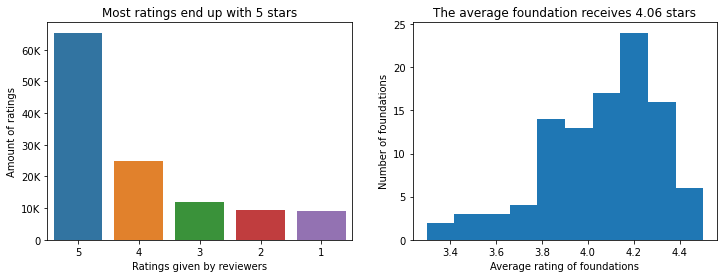

In [8]:
# hide
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x=all_data['rating'], order=all_data['rating'].value_counts().index, ax=ax1)
ax1.set_xlabel('Ratings given by reviewers')
ax1.set_ylabel('Amount of ratings')
ax1.title.set_text('Most ratings end up with 5 stars')
ax1.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
ax2.hist(all_data.groupby(['brand_product']).mean()['rating'], bins=10)
ax2.set_xlabel('Average rating of foundations')
ax2.set_ylabel('Number of foundations')
ax2.title.set_text('The average foundation receives 4.06 stars')

Out of 5 stars, most users give out 5 stars. More than 60K reviews end up with 5 stars.

When looking at the average ratings across all foundations, we see the distribution skews to the right, and the average foundation receives 4.06 stars.

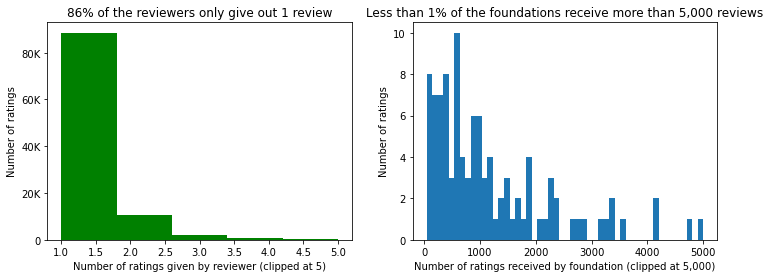

In [9]:
# hide
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# sns.countplot(x=all_data['rating'], order=all_data['rating'].value_counts().index, ax=ax1)
ax1.hist(all_data.groupby(['reviewer_id']).count()['rating'].clip(0,5), bins=5, color='green')
# sns.countplot(x=all_data.groupby(['reviewer_id']).count()['rating'],
              # order=sorted(all_data.groupby(['reviewer_id']).count()['rating'].value_counts().index), ax=ax1)
ax1.set_xlabel('Number of ratings given by reviewer (clipped at 5)')
ax1.set_ylabel('Number of ratings')
ax1.title.set_text('86% of the reviewers only give out 1 review')
ax1.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
ax2.hist(all_data.groupby(['brand_product']).count()['rating'].clip(0,5000), bins=50)#.plot.hist(ax=ax2)
ax2.set_xlabel('Number of ratings received by foundation (clipped at 5,000)')
ax2.set_ylabel('Number of ratings')
ax2.title.set_text('Less than 1% of the foundations receive more than 5,000 reviews')

+ 87% of the **reviewers** on Sephora only give out 1 review. Together they account for 73% of all reviews
+ 13% of the reviewers give out more than 2 reviews. Together they account for at least 23% of all reviews
+ Only 4 **foundations** receive >4,000 reviews, but these reviews account for at least 13% of all reviews
+ 58% of the foundations only have <1,000 reviews, and together they account for at most 48% of all reviews

In [10]:
# hide
(
    sum(all_data.groupby(['reviewer_id']).count()['rating']<2),
    sum(all_data.groupby(['reviewer_id']).count()['rating']<2) / len(all_data.groupby(['reviewer_id']).count()['rating']),
    sum(all_data.groupby(['reviewer_id']).count()['rating']<2) / len(all_data['rating']),
    sum(all_data.groupby(['reviewer_id']).count()['rating']>=2),
    sum(all_data.groupby(['reviewer_id']).count()['rating']>=2) / len(all_data.groupby(['reviewer_id']).count()['rating']),
    sum(all_data.groupby(['reviewer_id']).count()['rating']>=2) * 2 / len(all_data['rating'])
)

(88529,
 0.8667077850877193,
 0.73204997808704,
 13615,
 0.13329221491228072,
 0.22516600100882306)

In [11]:
# hide
(
    sum(all_data.groupby(['brand_product']).count()['rating']<=1000),
    sum(all_data.groupby(['brand_product']).count()['rating']<=1000) / len(all_data.groupby(['brand_product']).count()['rating']),
    sum(all_data.groupby(['brand_product']).count()['rating']<=1000) * 1000 / len(all_data['rating']),
    sum(all_data.groupby(['brand_product']).count()['rating']>=4000) ,
    sum(all_data.groupby(['brand_product']).count()['rating']>=4000) / len(all_data.groupby(['brand_product']).count()['rating']),
    sum(all_data.groupby(['brand_product']).count()['rating']>=4000) * 4000 / len(all_data['rating'])

)


(59,
 0.5784313725490197,
 0.4878734505883423,
 4,
 0.0392156862745098,
 0.1323046645663301)

In [12]:
fo = all_data.groupby(['brand', 'product'], as_index=False).agg({
        'rating': ['count', 'mean']
    }).sort_values(('rating', 'count'), ascending=False).reset_index(drop=True).head(5)
us = all_data.groupby(['reviewer_id'], as_index=False).agg({
        'rating': ['count', 'mean']
    }).sort_values(('rating', 'count'), ascending=False).reset_index(drop=True).head(5)
display_dfs_horiz([us, fo], ['Most active reviewers', 'Most rated foundations'])

Most active reviewers 
 
 
   
 reviewer_id 
 rating 
 
 
   
 
 count 
 mean 
 
 
 
 
 0 
 kueenquise 
 34 
 3.500000 
 
 
 1 
 jen101 
 34 
 4.147059 
 
 
 2 
 makeupgt5 
 22 
 4.272727 
 
 
 3 
 sgracemalone 
 20 
 4.200000 
 
 
 4 
 DressageQueen86 
 20 
 4.700000 
 
 
 

 
 Most rated foundations 
 
 
   
 brand 
 product 
 rating 
 
 
   
 
 
 count 
 mean 
 
 
 
 
 0 
 FENTY BEAUTY by Rihanna 
 Pro Filt'r Soft Matte Longwear Foundation 
 5300 
 3.946792 
 
 
 1 
 Too Faced 
 Born This Way Foundation 
 4796 
 3.990409 
 
 
 2 
 KVD Vegan Beauty 
 Lock-It Foundation 
 4207 
 3.895175 
 
 
 3 
 Rare Beauty by Selena Gomez 
 Liquid Touch Weightless Foundation 
 4131 
 4.131929 
 
 
 4 
 MAKE UP FOR EVER 
 Ultra HD Invisible Cover Foundation 
 3548 
 4.113021

Given the fact that there were only 102 foundations, it is amazing that people can have reviewed more than 20 of them!

Sometimes the brands give out free samples for people to review, and reviewers on Sephora voluntarily disclose whether they received the product for free. I wonder if they were gifted with the product by the companies:

In [13]:
gifted = all_data.groupby(['reviewer_id'], as_index=False).agg({
            'rating': ['count', 'mean'],
            'gifted': 'sum'
        }).sort_values(('rating', 'count'), ascending=False).reset_index(drop=True).head(5)
display_dfs_horiz([gifted], ['Most active reviewers if gifted'])

Most active reviewers if gifted 
 
 
   
 reviewer_id 
 rating 
 gifted 
 
 
   
 
 count 
 mean 
 sum 
 
 
 
 
 0 
 kueenquise 
 34 
 3.500000 
 0 
 
 
 1 
 jen101 
 34 
 4.147059 
 1 
 
 
 2 
 makeupgt5 
 22 
 4.272727 
 0 
 
 
 3 
 sgracemalone 
 20 
 4.200000 
 0 
 
 
 4 
 DressageQueen86 
 20 
 4.700000 
 0

Not really (or at least they did not disclose that information in the reviews)! It's amazing how passionate they are about foundations.

## What are the highest rated foundations?

In [74]:
ranking = all_data.groupby(['brand', 'product'], as_index=False).agg({
    'rating': 'mean'
}).sort_values(['rating'], ascending=False).reset_index(drop=True).head(10)
display_dfs_horiz([ranking], ['Top-rated Foundations'])

,brand,product,rating
0,HUDA BEAUTY,#FauxFilter Skin Finish Buildable Coverage Foundation Stick,4.502114
1,Bobbi Brown,Skin Long-Wear Weightless Foundation SPF 15,4.458261
2,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Powder Foundation,4.443439
3,IT Cosmetics,Your Skin But Better Foundation + Skincare,4.440639
4,Shiseido,Synchro Skin Self-Refreshing Custom Finish Powder Foundation,4.404494
5,Laura Mercier,Tinted Moisturizer Broad Spectrum SPF 20 - Oil Free,4.382095
6,Dior,BACKSTAGE Face & Body Foundation,4.373636
7,Lancôme,Teint Idole Ultra Long Wear Foundation,4.362036
8,Estée Lauder,Double Wear Stay-in-Place Foundation,4.330944
9,CLINIQUE,Stay-Matte Sheer Pressed Powder,4.311927


## Why do reviewers like or dislike a product?

In [117]:
sum(all_data[all_data['rating']==5]['finish']) / len(all_data[all_data['rating']==5])

0.1679434836460388

In [119]:
sum(all_data[all_data['rating']==5]['shade_match']) / len(all_data[all_data['rating']==5])

0.15555759438506353

In [121]:
sum(all_data[all_data['rating']==5]['coverage']) / len(all_data[all_data['rating']==5])

0.4597917335657599

In [120]:
all_data.columns

Index(['reviewer_id', 'rating', 'recommended', 'review_subject',
       'review_content', 'reviewer_feature', 'purchased_shade',
       'date_of_review', 'eye_color', 'hair_color', 'skin_tone', 'skin_type',
       'skin_tone_bin', 'skin_tone_cat', 'days_since_launch',
       'days_since_launch_scaled', 'month_of_purchase', 'finish', 'coverage',
       'shade_match', 'gifted', 'brand_product', 'brand', 'product', 'year'],
      dtype='object')

## Product longevity and rating?

Do foundations that have been around for longer tend to have higher ratings? I look at longevity with the time difference between the first and last reviews for each foundation. I found that:

+ 35 out of the 102 foundations have been on the Sephora website since 2017


(Note that the data was collected in Jan, 2022, so foundations that were taken down by Sephora before that are not included.)

In [41]:
# hide
all_data['year'] = pd.DatetimeIndex(all_data['date_of_review']).year

In [89]:
longevity = all_data.groupby(['brand', 'product'], as_index=False).agg({
            'year': ['first', 'last'],
            'rating': ['mean', 'std', 'count']
        }).sort_values([('year', 'first')], ascending=False)
longevity['years_elapsed'] = longevity[('year', 'first')] - longevity[('year', 'last')]
longevity = longevity.sort_values([('rating', 'mean')], ascending=False).reset_index(drop=True)
longevity = longevity.rename(columns={'first': 'latest', 'last': 'earliest'})

In [112]:
longevity[longevity['years_elapsed']>=5][('rating', 'mean')].mean

<bound method NDFrame._add_numeric_operations.<locals>.mean of 5    4.38
7    4.36
8    4.33
10   4.31
11   4.30
13   4.29
15   4.29
19   4.27
20   4.26
24   4.25
25   4.25
26   4.24
29   4.23
33   4.21
35   4.20
39   4.18
42   4.17
45   4.14
46   4.14
47   4.14
51   4.13
52   4.11
53   4.11
55   4.09
60   4.05
61   4.04
62   4.02
66   3.99
75   3.92
80   3.87
87   3.80
88   3.79
89   3.78
90   3.77
93   3.69
Name: (rating, mean), dtype: float64>

In [113]:
longevity[longevity['years_elapsed']<5][('rating', 'mean')].mean

<bound method NDFrame._add_numeric_operations.<locals>.mean of 0     4.50
1     4.46
2     4.44
3     4.44
4     4.40
6     4.37
9     4.31
12    4.30
14    4.29
16    4.29
17    4.28
18    4.28
21    4.26
22    4.26
23    4.26
27    4.24
28    4.24
30    4.23
31    4.22
32    4.21
34    4.20
36    4.20
37    4.20
38    4.19
40    4.18
41    4.17
43    4.17
44    4.15
48    4.13
49    4.13
50    4.13
54    4.10
56    4.08
57    4.08
58    4.07
59    4.06
63    4.02
64    4.01
65    4.00
67    3.97
68    3.95
69    3.94
70    3.94
71    3.93
72    3.93
73    3.93
74    3.92
76    3.90
77    3.88
78    3.88
79    3.88
81    3.86
82    3.85
83    3.84
84    3.83
85    3.82
86    3.81
91    3.73
92    3.69
94    3.62
95    3.58
96    3.56
97    3.52
98    3.52
99    3.44
100   3.42
101   3.30
Name: (rating, mean), dtype: float64>

In [107]:
longevity.groupby(['years_elapsed'], as_index=False).mean()[['years_elapsed', 'rating']]

/opt/homebrew/Caskroom/miniforge/base/envs/foundation/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


years_elapsed rating              
                  mean  std    count
0             0   3.87 1.31   794.50
1             1   4.10 1.20 1,165.33
2             2   4.23 1.09 1,295.62
3             3   3.95 1.32 1,088.00
4             4   3.99 1.30 1,186.04
5             5   4.12 1.26 1,256.83

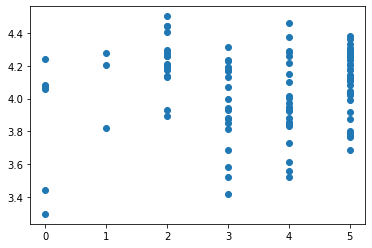

In [88]:
plt.scatter(x = longevity['years_elapsed'], y = longevity[('rating','mean')])

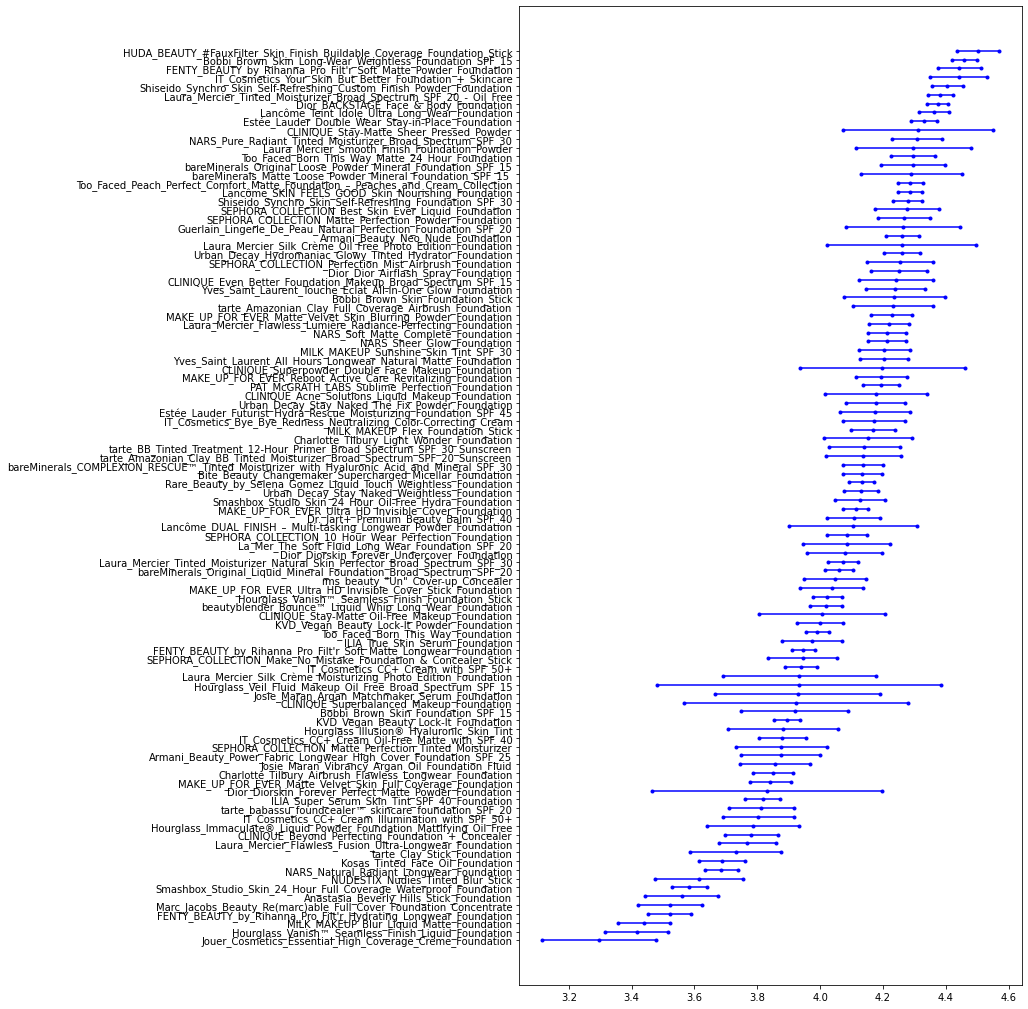

In [32]:
plt.figure(figsize=(9,18))
plot_diff_in_means(data = all_data, col1='brand_product')

In [18]:
all_data.groupby(['brand', 'product'], as_index=False).median()[['brand', 'product', 'date_of_review']]

KeyError: "['date_of_review'] not in index"

In [17]:
pd.to_datetime(all_data['date_of_review'])

0     1970-01-01 00:27:23.673600
1     1970-01-01 00:27:21.859200
2     1970-01-01 00:27:21.772800
3     1970-01-01 00:27:21.686400
4     1970-01-01 00:27:21.686400
                 ...            
478   1970-01-01 00:25:04.310400
479   1970-01-01 00:25:04.224000
480   1970-01-01 00:25:04.224000
481   1970-01-01 00:25:04.051200
482   1970-01-01 00:25:04.051200
Name: date_of_review, Length: 120933, dtype: datetime64[ns]

  0%|          | 0/120933 [00:00<?, ?it/s]


ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

In [27]:
len('1643673600000')

13

In [198]:
all_data.groupby(['brand', 'product'], as_index=False).mean()[['brand', 'product', 'rating']]

KeyError: False

In [197]:
all_data.groupby(['brand', 'product'], as_index=False).mean()[['brand', 'product', 'rating']].reset_index(drop=True).sort_values(['rating'], ascending=False)

,brand,product,rating
27,HUDA BEAUTY,#FauxFilter Skin Finish Buildable Coverage Fou...,4.50
6,Bobbi Brown,Skin Long-Wear Weightless Foundation SPF 15,4.46
25,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Powder Foundation,4.44
39,IT Cosmetics,Your Skin But Better Foundation + Skincare,4.44
79,Shiseido,Synchro Skin Self-Refreshing Custom Finish Pow...,4.40
55,Laura Mercier,Tinted Moisturizer Broad Spectrum SPF 20 - Oil...,4.38
16,Dior,BACKSTAGE Face & Body Foundation,4.37
49,Lancôme,Teint Idole Ultra Long Wear Foundation,4.36
21,Estée Lauder,Double Wear Stay-in-Place Foundation,4.33
11,CLINIQUE,Stay-Matte Sheer Pressed Powder,4.31


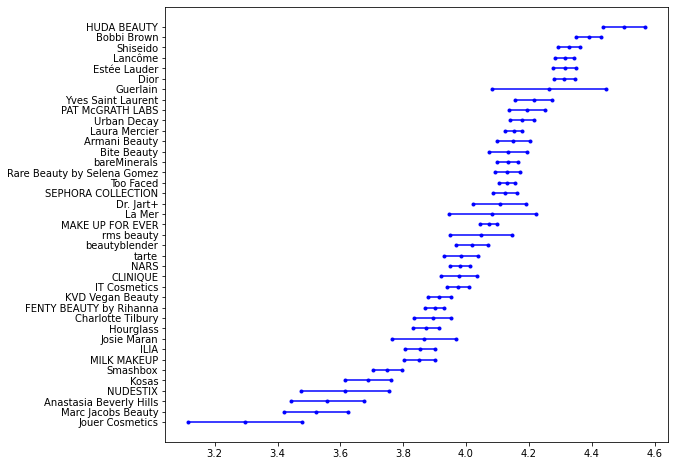

brand_product
Anastasia_Beverly_Hills_Stick_Foundation                                                       594
Armani_Beauty_Neo_Nude_Foundation                                                             1203
Armani_Beauty_Power_Fabric_Longwear_High_Cover_Foundation_SPF_25                               484
Bite_Beauty_Changemaker_Supercharged_Micellar_Foundation                                      1344
Bobbi_Brown_Skin_Foundation_SPF_15                                                             270
Bobbi_Brown_Skin_Foundation_Stick                                                              191
Bobbi_Brown_Skin_Long-Wear_Weightless_Foundation_SPF_15                                       2300
CLINIQUE_Acne_Solutions_Liquid_Makeup_Foundation                                               202
CLINIQUE_Beyond_Perfecting_Foundation_+_Concealer                                             1016
CLINIQUE_Even_Better_Foundation_Makeup_Broad_Spectrum_SPF_15                                   

In [98]:
sorted(all_data.groupby(['brand_product']).count()['rating'].value_counts(sort=True, ascending=True).index)

[44,
 66,
 77,
 81,
 104,
 109,
 112,
 136,
 164,
 165,
 172,
 182,
 191,
 202,
 231,
 260,
 270,
 317,
 323,
 324,
 330,
 333,
 349,
 370,
 387,
 397,
 399,
 403,
 420,
 438,
 477,
 483,
 484,
 543,
 562,
 572,
 573,
 580,
 592,
 594,
 597,
 634,
 656,
 681,
 703,
 721,
 748,
 764,
 786,
 846,
 858,
 884,
 888,
 893,
 907,
 946,
 947,
 969,
 1016,
 1019,
 1025,
 1055,
 1068,
 1126,
 1187,
 1203,
 1222,
 1226,
 1249,
 1344,
 1375,
 1467,
 1514,
 1517,
 1547,
 1678,
 1714,
 1765,
 1835,
 1868,
 1897,
 1917,
 2102,
 2167,
 2262,
 2300,
 2320,
 2344,
 2356,
 2638,
 2761,
 2901,
 3162,
 3300,
 3332,
 3348,
 3548,
 4131,
 4207,
 4796,
 5300]

In [69]:
all_data.groupby(['reviewer_id']).count()['rating'].sort_values(ascending=False).mean()

1.1839461936090225

In [58]:
all_data.groupby(['brand_product']).mean()['rating']

brand_product
Anastasia_Beverly_Hills_Stick_Foundation                                                     3.56
Armani_Beauty_Neo_Nude_Foundation                                                            4.26
Armani_Beauty_Power_Fabric_Longwear_High_Cover_Foundation_SPF_25                             3.87
Bite_Beauty_Changemaker_Supercharged_Micellar_Foundation                                     4.13
Bobbi_Brown_Skin_Foundation_SPF_15                                                           3.92
Bobbi_Brown_Skin_Foundation_Stick                                                            4.24
Bobbi_Brown_Skin_Long-Wear_Weightless_Foundation_SPF_15                                      4.46
CLINIQUE_Acne_Solutions_Liquid_Makeup_Foundation                                             4.18
CLINIQUE_Beyond_Perfecting_Foundation_+_Concealer                                            3.78
CLINIQUE_Even_Better_Foundation_Makeup_Broad_Spectrum_SPF_15                                 4.24
CLINIQ

In [64]:
np.mean(all_data['rating'])

4.059975358256224

In [56]:
len(all_data.groupby(['brand_product']).count()['rating'])

102

In [57]:
len(all_data.groupby(['brand']).count()['rating'])

39

In [107]:
all_data.groupby(['brand_product']).count()['rating'].value_counts()

580     2
594     1
572     1
1517    1
4131    1
1678    1
330     1
1467    1
1375    1
846     1
3162    1
907     1
947     1
1187    1
1222    1
681     1
3548    1
748     1
1765    1
1226    1
2638    1
2167    1
172     1
104     1
721     1
387     1
562     1
1068    1
349     1
483     1
323     1
399     1
634     1
2262    1
573     1
1868    1
231     1
1514    1
543     1
1055    1
1835    1
403     1
1126    1
3332    1
858     1
4796    1
1025    1
2320    1
1714    1
136     1
969     1
1203    1
81      1
1917    1
420     1
3348    1
888     1
477     1
77      1
786     1
3300    1
317     1
1897    1
66      1
2102    1
109     1
165     1
397     1
1016    1
202     1
2300    1
191     1
270     1
1344    1
484     1
5300    1
884     1
182     1
946     1
2356    1
164     1
333     1
1547    1
1019    1
4207    1
324     1
656     1
112     1
438     1
2761    1
1249    1
597     1
592     1
703     1
2344    1
44      1
893     1
2901    1
370     1
260     1
